In [1]:
import sys
sys.path.append("../../src")

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import os
from spring_example import get_spring_data, spring_to_movie, generate_spring_data
from scipy.integrate import odeint, solve_ivp
from autoencoder import full_network
from training import create_feed_dictionary
from sindy_utils import sindy_simulate

In [2]:
num_examples = 4
train_data = get_spring_data(num_examples)

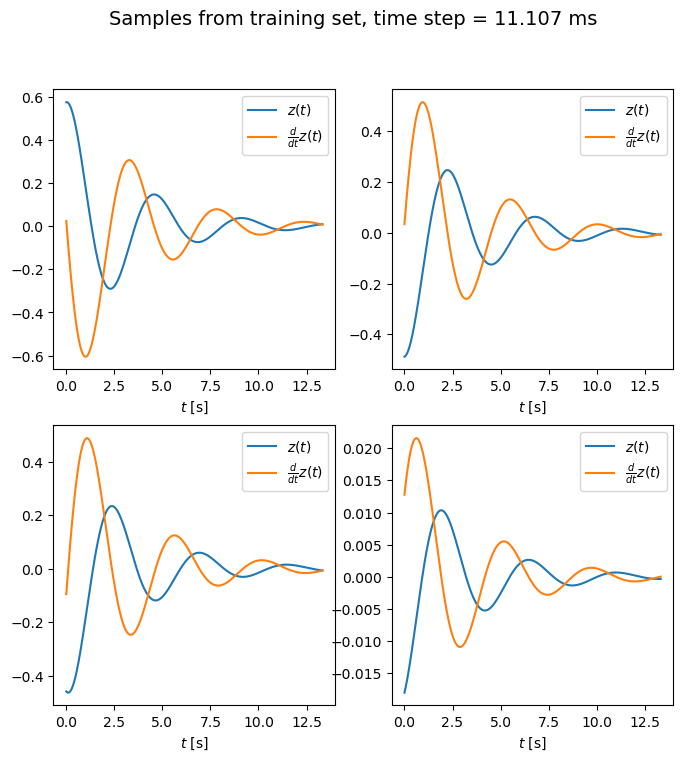

In [3]:

t = train_data['t']
z = train_data['z']
dz = train_data['dz']
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
fig.suptitle(f"Samples from training set, time step = {np.round((t[1]-t[0])*1000, 3)} ms", fontsize=14)

for i in range(num_examples):
    axes[i].plot(t, z[len(t)*i : len(t)*(i+1)], label='$z(t)$')
    axes[i].plot(t, dz[len(t)*i : len(t)*(i+1)], label=r'$\frac{d}{dt}z(t)$') # first derivative dx
    axes[i].legend()
    axes[i].set_xlabel('$t$ [s]')
plt.show()

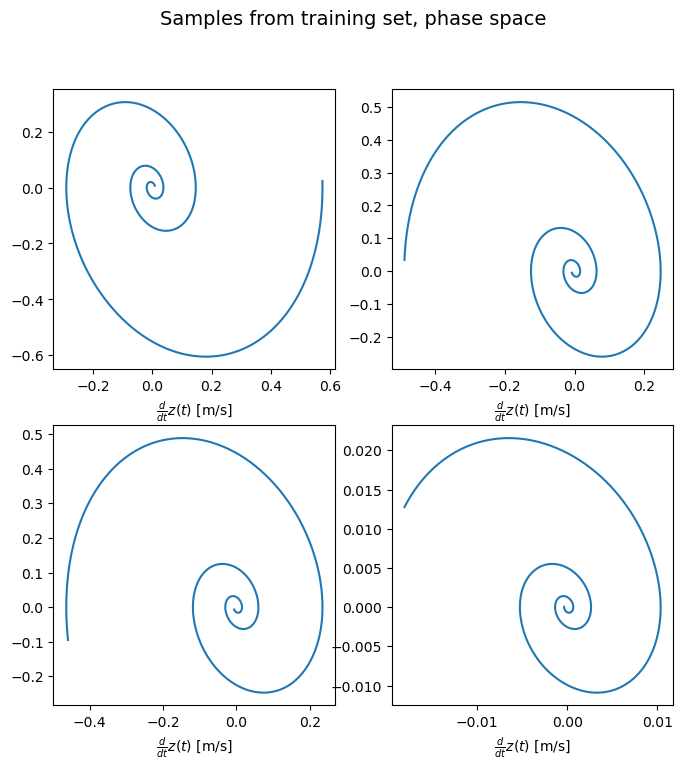

In [4]:
t = train_data['t']
z = train_data['z']
dz = train_data['dz']
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()
fig.suptitle(f"Samples from training set, phase space", fontsize=14)

for i in range(num_examples):
    axes[i].plot(z[len(t)*i : len(t)*(i+1)], dz[len(t)*i : len(t)*(i+1)])
    axes[i].set_xlabel('$z(t)$ [m]')
    axes[i].set_xlabel(r'$\frac{d}{dt}z(t)$ [m/s]')
plt.show()

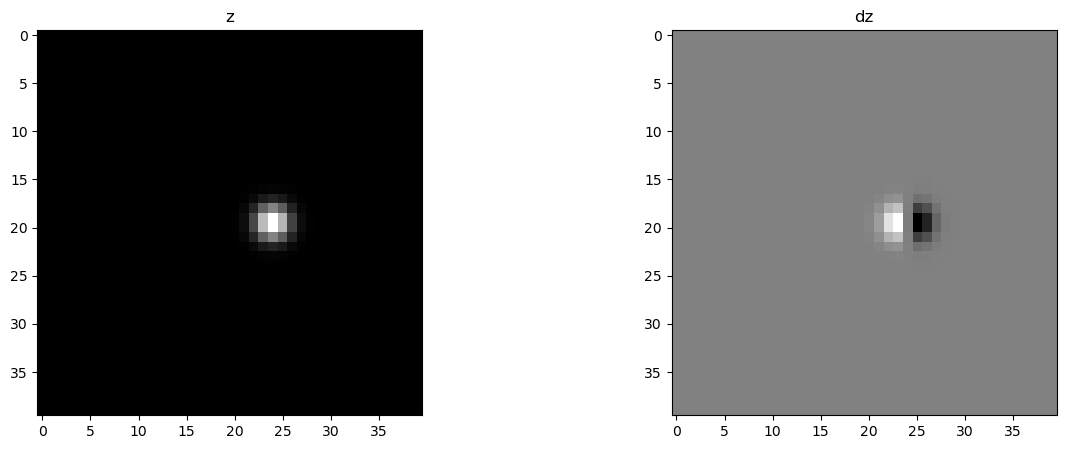

In [6]:
x = train_data['x'] 
dx = train_data['dx'] 
n = int(np.sqrt(x.shape[1]))

from matplotlib.animation import FuncAnimation

# Assuming train_data, n, and other variables are defined

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Function to update the plot for each frame
def update(frame):
    ax[0].clear()
    ax[1].clear()

    ax[0].imshow(x[frame, :].reshape(n, n), cmap="gray")
    ax[0].set_title('z')

    ax[1].imshow(dx[frame, :].reshape(n, n), cmap="gray")
    ax[1].set_title('dz')
    
# Create the animation
animation = FuncAnimation(fig, update, frames=range(0, len(t), 10), interval=int((t[1]-t[0])*1000*10))
animation.save('your_animation.gif', writer='pillow')  # for gif

#plt.show()

### Evaluate the obtained model (from the training) on a test set

In [12]:
# get the parameters obtained from the training of the sindy autoencoder NN
data_path = os.getcwd() + '/'
save_name = 'experiment_results_1'
params = pickle.load(open(data_path + save_name + '.pkl', 'rb'))
params['save_name'] = data_path + save_name
# Get the first row as a Series
first_row = params.iloc[0]

# Convert the Series to a dictionary
loaded_data_dict = first_row.to_dict()


autoencoder_network = full_network(loaded_data_dict)
learning_rate = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
saver = tf.compat.v1.train.Saver(var_list=tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

Instructions for updating:
Use `tf.cast` instead.


In [11]:
# and evaluate the latent varibles z(t) given one initial condition
dt = .01
t = np.arange(0, 20, dt)
z0s = np.pi/np.array([1.5,2,3,4,8,16])
dz0s = .5*np.ones(z0s.shape)

n_ics = z0s.size

z_test = np.zeros((n_ics,t.size,2))
dz_test = np.zeros(z_test.shape)

for i in range(n_ics):
    z_test[i] = solve_ivp(spring_f, 
                    t_span = (t[0], t[-1]), 
                    y0 = [z0s[i], dz0s[i]],
                    t_eval = t).y.T
    #z_test[i] = odeint(spring_f, t, [z0s[i],dz0s[i]])
    dz_test[i] = np.array([spring_f(t[j], z_test[i,j]) for j in range(len(t))])

x, dx, ddx = spring_to_movie(z_test, dz_test)

In [13]:
num_examples = 10
test_data = get_spring_data(num_examples)


In [14]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

ValueError: The passed save_path is not a valid checkpoint: C:\Users\milos\OneDrive\IX_semestar_master\masinsko ucenje\SindyAutoencoders\examples\spring/experiment_results_1

In [15]:
test_set_results['sindy_coefficients']
#params

NameError: name 'test_set_results' is not defined

In [19]:
true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)

true_coefficients[1] = -params_f['k']/params_f['m'] 
true_coefficients[2] = -params_f['b']/params_f['m'] 

n_ics = 1
z_sim = np.zeros((n_ics, t.size, 2))
spring_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate_order2(test_set_results['z'][i*t.size], test_set_results['dz'][i*t.size], t,
                                     params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                     params['poly_order'], params['include_sine'])
    spring_sim[i] = sindy_simulate_order2(test_data['z'][i*t.size], test_data['dz'][i*t.size], t,
                                            true_coefficients,
                                            params['poly_order'], params['include_sine'])

([], [])

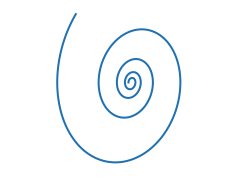

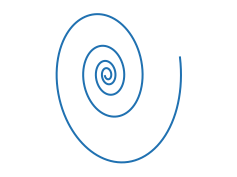

In [20]:
# PLOT THE ATTRACTOR IN THE PREDICTED CASE (with predicted coefficients) AND IN THE SIMULATED CASE (with true coefficients)
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,:,0].T, z_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(spring_sim[:,:,0].T, spring_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

<ipython-input-23-8882e7b5cc75>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)


(-99.95, 2098.95, -6.603767905752014, 4.554572848303081)

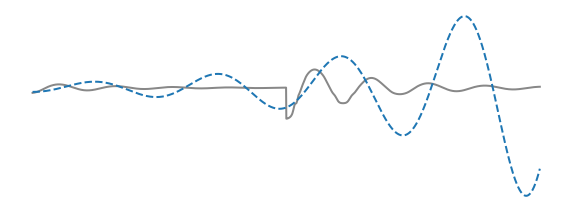

In [23]:
# plot the trajectory of the latent variable z(t) considering one initial condition
ic_idx = 0 

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

In [22]:
# evaluate the results of the test set on several initial conditions
test_data = get_spring_data(10)
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_ddx_error = np.mean((test_data['ddx'] - test_set_results['ddx_decode'])**2)/np.mean(test_data['ddx']**2)
sindy_ddz_error = np.mean((test_set_results['ddz'] - test_set_results['ddz_predict'])**2)/np.mean(test_set_results['ddz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_ddx_error)
print('SINDy relative error, z: %f' % sindy_ddz_error)

Decoder relative error: 0.005633
Decoder relative SINDy error: 0.820983
SINDy relative error, z: 0.093087
